In [9]:
import numpy as np
import matplotlib.pyplot as plt
from library.lisa_psd import noise_psd_AE, noise_psd_AE_gal2
import scipy.constants as constants
from library.snr import optimal_snr
import h5py

In [10]:
def power_spectrum_calc(h, f):
    """
    Function to compute the power spectrum of data

    Parameters
    ----------
    h : array_like
        Strain data
        
    f : array_like
         frequency of data

    Returns
    -------
    psd : One-sided PSD [strain^2 / Hz]
    """
    if h is None or f is None:
        return None

    h = np.asarray(h)
    f = np.asarray(f)
    
    # Frequency bin width
    df = f[1] - f[0]

    psd = np.abs(h)**2 *df
    if len(h) > 1:
        psd[1:-1] *= 2

    return psd


def pre_excluded_conf(sources, weak_indices, global_fr):
    """ 
    To calculate the confusion PSD of the pre-excluded sources (from estimated PSD)
    """
    psd_conf = np.zeros_like(global_fr)

    if len(weak_indices) == 0:
        return psd_conf
    
    psd_estimates = sources['source_psd_estimate'][weak_indices]
    f0_values = sources['f0'][weak_indices]

    freq_indices = np.searchsorted(global_fr, f0_values)
    freq_indices = np.clip(freq_indices, 0, len(global_fr) -1 )

    np.add.at(psd_conf, freq_indices, psd_estimates)
    
    return psd_conf

In [ ]:
def setup(sources, snr_calculator, psd_instrumental, snr_threshold=7.0):
    """
    Setup - prepare everything before starting the iteration
    
    Parameters:
    -----------
    sources : dictionary 
        must contain: 
        - 'f0' : (n_sources,) array with all f0
        - 'A' : (n_sources, ) array with all A channel response
        - 'E' : same as above for E channel
        - 'fr' : (n_sources, N) array with all frequencies 
        - 'psd_instr' : (n_sources, N) array with all PSD 
                     
        
    snr_calculator : function
    psd_instrumental : function
    df: delta_frequency for the global grid
    snr_threshold : float
        SNR threshold (default is 7.0)
        
    Returns:
    --------
    state : dictionary
        Contains all data needed for iteration
    """
    
    n_sources = len(sources['f0'])
    with_wf = sources.get('with_wf', np.ones(n_sources, dtype=bool))
    
    # Separate indices of sources with/without waveform
    wf_indices = np.where(with_wf)[0]
    weak_indices = np.where(~with_wf)[0]

    print(f"Starting with: {n_sources} total sources")
    print(f"Pre-excluded (no waveform): {len(weak_indices)}")
    print(f"POssible candidates (with waveform): {len(wf_indices)}")

    # Create global frequency grid (sample sources to avoid uploading all of them at the same time)
    # Useful for global PSD calculation
    df = None
    freq_min = np.inf
    freq_max = -np.inf

    for idx in wf_indices:
        fr = sources['fr'][idx]
        if fr is None:
            continue

        if df is None:
            df = fr[1] - fr[0]

        freq_min = min(freq_min, fr[0])
        freq_max = max(freq_max, fr[-1])

    global_fr = np.arange(freq_min - df, freq_max + 2*df, df)    

    # Calculate global PSD instr and confusion from pre-excluded sources
    psd_instr_global = psd_instrumental(global_fr, L= 2.5e9/constants.c, tdi = 1.5)
    psd_conf_preexcluded = pre_excluded_conf(sources, weak_indices, global_fr)
    
    state = {
        'waveforms': sources,
        'idx_unresolved': wf_indices.copy(),
        'idx_pre_excluded': weak_indices,
        'sources_resolved': [],
        'psd_instr_global': psd_instr_global,
        'psd_conf_preexcluded': psd_conf_preexcluded,
        'calculate_snr': snr_calculator,
        'snr_threshold': snr_threshold,
        'iteration': 0,
        'history': [],
        'global_fr': global_fr,
        'df': df,
        'freq_min': global_fr.min(),
        'freq_max': global_fr.max()
    }
    
    return state


def get_source_by_index(sources, idx):
    """
    Extract a single source from the sources dictionary
    
    """
    source = {}
    
    for key, value in sources.items():
        if isinstance(value, np.ndarray):
            if value.ndim == 1:
                # Scalar parameter (like f0)
                source[key] = value[idx]
            elif value.ndim == 2:
                # Array parameter (like A_channel, frequencies)
                source[key] = value[idx, :]
        elif isinstance(value, list):
            source[key] = value[idx]
        else:
            # Other types, just copy
            source[key] = value
    
    source['id'] = idx
    
    return source


def estimate_global_confusion_psd(sources, indices, psd_conf_preexcluded, calculate_power_function, 
                                   global_fr,  method='median', plot=True):
    """
    Calculate confusion PSD from unresolved sources
    
    Parameters:
    -----------
    sources : dict of arrays
        Full sources dictionary
    
    indices : array
        Indices of unresolved sources
        
    calculate_power_function : function 
        
    global_fr : array
        The global frequency grid
    method : str
        'median' or 'mean'
        
    Returns:
    --------
    psd_confusion_global : array
        Confusion PSD 
    """
    
    if len(indices) == 0:
        return psd_conf_preexcluded
    
    power_lists = [[] for _ in range(len(global_fr))]
    
    for idx in indices:
        source = get_source_by_index(sources, idx)

        power = calculate_power_function(source)
        source_freqs = source['fr']

        idx_start = np.argmin(np.abs(global_fr - source_freqs[0]))
        idx_end = idx_start + len(source_freqs)

        #mask = (global_fr >= source_freqs[0]) & (global_fr <= source_freqs[-1])
        # Interpolate source's freq to the global grid
        #power_interpolated = np.interp(
        #    global_fr[mask],      
        #    source_freqs,   
        #    power
        #)

        # Add to the lists
        for j, p in enumerate(power):
            if p > 0: 
                power_lists[idx_start +  j].append(p)

    psd_confusion_waveforms = np.zeros_like(global_fr)
    
    if method == 'median':
        for j in range(len(global_fr)):
            if len(power_lists[j]) > 0:
                psd_confusion_waveforms[j] = np.median(power_lists[j])
    elif method == 'mean':  
        for j in range(len(global_fr)):
            if len(power_lists[j]) > 0:
                psd_confusion_waveforms[j] = np.mean(power_lists[j])
    else:
        raise ValueError("Method must be 'median' or 'mean'")
    
    psd_confusion_global = psd_confusion_waveforms + psd_conf_preexcluded

    if plot:
        plt.loglog(global_fr, psd_confusion_global, label='Confusion PSD', color='teal', alpha=0.5)
        plt.loglog(global_fr, noise_psd_AE(global_fr, 2.5e9/constants.c, 1.5), label = 'Instrumental PSD', color = 'black')
        #plt.loglog(global_fr, noise_psd_AE_gal2(global_fr, 2.5e9/constants.c, 4*365*24*3600, 1.5), label = 'Galactic confusion model', color = 'red', alpha = 0.7)
        plt.ylim(1e-52, 1e-37)
        plt.grid(color='lightgrey')
        plt.legend()
        plt.show()
            
    return psd_confusion_global

def extract_psd_instr_for_source(source, global_fr, psd_instrumental_global):
    """
    Extract the relevant portion of global instrumental PSD for the source

    """
    source_freqs = source['fr']

    idx_start = np.argmin(np.abs(global_fr - source_freqs[0]))
    idx_end = idx_start + len(source_freqs)
    # mask = (global_fr >= source_freqs[0]) & (global_fr <= source_freqs[-1])

    
#    psd_instr_source = np.interp(
#        source_freqs[mask],          
#        global_fr,             
#        psd_instrumental_global
#    )

    psd_instr_source = psd_instrumental_global[idx_start:idx_end]

    return psd_instr_source

def extract_confusion_for_source(source, psd_confusion_global, global_fr):
    """
    Extract the relevant portion of global confusion PSD for this source
    
    """
    
    source_freqs = source['fr']
    mask = (global_fr >= source_freqs[0]) & (global_fr <= source_freqs[-1])
    idx_start = np.searchsorted(global_fr, source_freqs[0])
    idx_end   = idx_start + len(source_freqs)
    
    #psd_confusion_source = np.interp(
    #    source_freqs[mask],
    #    global_fr,
    #    psd_confusion_global
    #)

    psd_confusion_source= psd_confusion_global[idx_start:idx_end]
    return psd_confusion_source



def separate_snr(sources, indices, psd_instrumental_global, psd_confusion_global, global_fr, calculate_snr_function, threshold):
    """
    Separate sources into resolved vs unresolved based on SNR
        
    Returns:
    --------
    resolved : Resolved sources with their SNRs
    unresolved_idx : indices of unresolved sources to use in the next iteration
    """
    
    resolved = []
    unresolved_idx = []
    
    for idx in indices:
        # Get the source
        source = get_source_by_index(sources, idx)
        
        # Extract and add confusion PSD
        psd_confusion = extract_confusion_for_source(
            source, psd_confusion_global, global_fr
        )
        
        psd_instr = extract_psd_instr_for_source(source, global_fr, psd_instrumental_global )

        # Add to instrumental PSD to get total PSD
        source['psd_total'] = psd_instr + psd_confusion

        snr = calculate_snr_function(source)
        
        if snr > threshold:
            resolved.append({'source': source, 'snr': snr})
        else:
            unresolved_idx.append(idx)
    
    return resolved, np.array(unresolved_idx)

def save_resolved_sources(output_file, resolved_sources, n_total, snr_threshold, T_obs):
    """
    Save function for resolved sources
    
    """
    import h5py
    
    n_resolved = len(resolved_sources)
    
    with h5py.File(output_file, 'w') as f:
        
        f.attrs['n_resolved'] = n_resolved
        f.attrs['n_total'] = n_total
        f.attrs['snr_threshold'] = snr_threshold
        f.attrs['T_obs'] = T_obs
        
        f.create_dataset('f0', shape=(n_resolved,), dtype='float64')
        f.create_dataset('amplitude', shape=(n_resolved,), dtype='float64')
        f.create_dataset('snr', shape=(n_resolved,), dtype='float64')
        f.create_dataset('ecliptic_lat', shape=(n_resolved,), dtype='float64')
        f.create_dataset('ecliptic_lon', shape=(n_resolved,), dtype='float64')
        
        for i, entry in enumerate(resolved_sources):
            source = entry['source']
            f['f0'][i] = source['f0']
            f['amplitude'][i] = source['Ampl']
            f['snr'][i] = entry['snr']
            f['ecliptic_lat'][i] = source.get('ecliptic_lat', np.nan)
            f['ecliptic_lon'][i] = source.get('ecliptic_lon', np.nan)


def run_iterative_separation(state, calculate_power_function, 
                             max_iterations=100, 
                             conv_tolerance=1e-3,
                             confusion_method='median',
                             print_progress=True,
                             save_results= True,
                             output_file= 'resolved_sources.hdf5'):
    """    
    Parameters:
    -----------
    state : dictionary
        State from setup_separation()
    calculate_power_function : function
    max_iterations : int
    conv_tolerance : float
        Stop when fraction of newly resolved < this value
    confusion_method : str
        'median' or 'mean'
    print_progress : bool
        Print what's happening at each step
        
    Returns:
    --------
    results : dictionary
        Final results with resolved/unresolved sources
    """
    
    n_tot_sources = len(state['waveforms']['f0'])
    n_pre_confusion = len(state['idx_preexcluded'])

    if print_progress:
        print(f"Starting with {n_tot_sources} total sources")
        print(f"{n_pre_confusion} sources already pre-excluded and added to the confusion")
        print(f"{len(state["idx_unresolved"])} candidate sources to run the iteration")
        print(f"Frequency range: {state['freq_min']:.2e} to {state['freq_max']:.2e} Hz")
        print(f"SNR threshold: {state['snr_threshold']}")
        


    snr_instr = np.zeros(n_tot_sources)
    
    # for idx in state['idx_unresolved']:
    #    binary = get_source_by_index(state['waveforms'], idx)
    #    binary['psd_total'] = state['psd_instr_global'] # No confusion 
    #    snr_instr[idx] = state['calculate_snr'](binary)
    
    
    n_resolved_previous = len(state['sources_resolved'])
    
    # MAIN ITERATION LOOP
    for iteration in range(1, max_iterations + 1):
        
        if print_progress:
            print(f"\n--- Iteration {iteration} ---")
        
        # STEP 1: Calculate global confusion PSD
        psd_confusion_global = estimate_global_confusion_psd(
            state['waveforms'],
            state['idx_unresolved'],
            state['psd_conf_preexcluded'],
            calculate_power_function,
            state['global_fr'],
            method=confusion_method,
            plot =True
        )
        
        # STEP 2: Separate sources with updated confusion
        resolved_new, unresolved_idx = separate_snr(
            state['waveforms'],
            state['idx_unresolved'],
            state['psd_instr_global'],
            psd_confusion_global,
            state['global_fr'],
            state['calculate_snr'],
            state['snr_threshold']
        )
        
        # STEP 3: Update state 
        state['sources_resolved'].extend(resolved_new)
        state['idx_unresolved'] = unresolved_idx
        
        n_resolved_now = len(state['sources_resolved'])
        
        state['history'].append({
            'iteration': iteration,
            'n_resolved_this_step': len(resolved_new),
            'n_unresolved_remaining': len(state['idx_unresolved']),
            'n_resolved_total': n_resolved_now
        })
        
        if print_progress:
            print(f"  New resolved: {len(resolved_new)}")
            print(f"  Still unresolved: {len(state['idx_unresolved'])}")
            print(f"  Total resolved: {n_resolved_now}")
        
        # STEP 4: Check convergence
        n_newly_resolved = n_resolved_now - n_resolved_previous
        
        if n_newly_resolved == 0:
            if print_progress:
                print(f"\nConverged after {iteration} iterations!")
            break
        
        n_resolved_previous = n_resolved_now
        
        if len(state['idx_unresolved']) == 0:
            if print_progress:
                print(f"\nAll sources resolved after {iteration} iterations! :)")
            break
    
    else:
        if print_progress:
            print(f"\nReached maximum iterations ({max_iterations})")
    
    results = {
        'resolved_sources': state['sources_resolved'],
        'unresolved_indices': state['idx_unresolved'],
        'n_resolved': len(state['sources_resolved']),
        'n_unresolved': len(state['idx_unresolved']),
        'iterations': iteration,
        'history': state['history']
    }
    
    if print_progress:
        print("\n" + "=" * 60)
        print("FINAL RESULTS:")
        print(f"  Total sources: {n_tot_sources}")
        print(f"  Resolved: {results['n_resolved']} ({results['n_resolved']/n_tot_sources*100:.1f}%)")
        print(f"  Unresolved: {n_tot_sources-results['n_resolved']} ({100 - results['n_resolved']/n_tot_sources*100:.1f}%)")
        print("=" * 60)
    
    if save_results:
        if print_progress:
            print(f"\nSaving resolved sources to {output_file}...")
        
        save_resolved_sources(
            output_file,
            state['sources_resolved'],
            n_tot_sources,
            state['snr_threshold'],
            state.get('T_obs', state['waveforms'].get('T_obs', 0))
        )
        
        if print_progress:
            print(f"Saved {results['n_resolved']} resolved sources")
    
    return results

USAGE: 

Need to provide a list of sources to setup the state

In [12]:
import h5py

def load_waveforms_as_dict(filename):
    data = {
        'A': [],
        'E': [],
        'fr': [],
        'source_psd_estimate': [],
        'f0': [],
        'Ampl': [],
        'with_wf': [],
        'ecliptic_lat': [],
        'ecliptic_lon': []
    }

    with h5py.File(filename, 'r') as f:
        n_tot = len(f['meta/f0'])

        # Pre-allocate lists
        data['A'] = [None] * n_tot
        data['E'] = [None] * n_tot
        data['fr'] = [None] * n_tot
        data['ecliptic_lat'] = [None] * n_tot  
        data['ecliptic_lon'] = [None] * n_tot
        data['with_wf'] = np.zeros(n_tot, dtype = bool) # Track sources with a waveform to shorten iteration

        data['source_psd_estimate'] = f['source_psd_estimate'][:]
        data['f0'] = f['meta/f0'][:]
        data['Ampl'] = f['meta/Ampl'][:]

        for bucket in ['small', 'medium', 'large']:
            grp = f[bucket]
            idx = grp['indices'][:]

            for i, global_idx in enumerate(idx):
                data['A'][global_idx]  = grp['A'][i]
                data['E'][global_idx]  = grp['E'][i]
                data['fr'][global_idx] = grp['fr'][i]
                data['ecliptic_lat'][global_idx] = grp['ecliptic_lat'][i]  
                data['ecliptic_lon'][global_idx] = grp['ecliptic_lon'][i]
                data['with_wf'][global_idx] = True

    return data


In [13]:
data_test = load_waveforms_as_dict("binaries_test_all_SNR_selection")

In [14]:
n_has = 0
indices = []

for i, a in enumerate(data_test['A']):
    if a is not None:
        n_has += 1
        indices.append(i)

print(f"With waveform: {n_has}")
print(f"Without waveform: {len(data_test['A']) - n_has}")
#print("Indices with waveform:", indices)

with h5py.File("binaries_test_1000000_SNR_selection", "r") as f:
    for bucket in ["small", "medium", "large"]:
        n = len(f[bucket]["indices"])
        print(f"{bucket}: {n} sources")
    
    large_indices = f["large"]["indices"][:]
    #print("Indices in 'large' bucket:", large_indices)


With waveform: 365502
Without waveform: 15173822
small: 24710 sources
medium: 19 sources
large: 11 sources


In [15]:
sources = data_test
T_obs = 4*365*24*3600
state = setup(sources, snr_calculator= lambda source: optimal_snr(source["A"], source["psd_total"], T_obs=T_obs), psd_instrumental=noise_psd_AE,df = 1e-5, snr_threshold=7)


Starting with: 15539324 total sources
Pre-excluded (no waveform): 15173822
POssible candidates (with waveform): 365502


Starting with 15539324 total sources
2024 sources already pre-excluded and added to the confusion
365502 candidate sources to run the iteration
Frequency range: 1.65e-04 to 2.04e-02 Hz
SNR threshold: 7

--- Iteration 1 ---


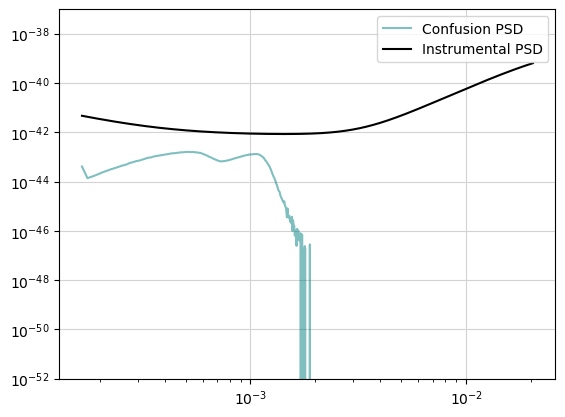

IndexError: boolean index did not match indexed array along axis 0; size of axis is 8 but size of corresponding boolean axis is 2024

In [16]:
results = run_iterative_separation(state, calculate_power_function=lambda source: power_spectrum_calc(source["A"], source["fr"]), max_iterations=50, conv_tolerance=0.001, confusion_method= 'median', print_progress=True, save_results=True, output_file= 'resolved_sources_1000000.hdf5')